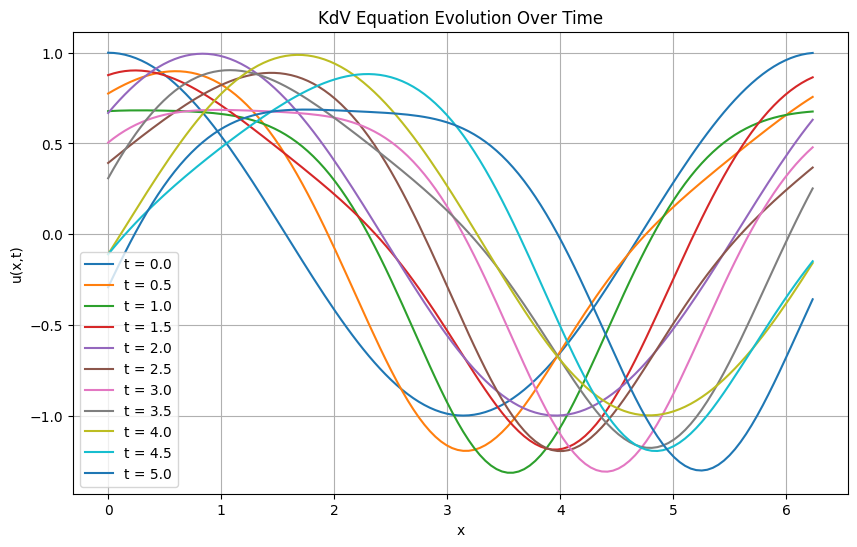

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Parameters
L = 2 * np.pi  # Domain length (periodic)
N = 128        # Number of grid points
dx = L / N     # Grid spacing
dt = 0.001     # Time step
T = 5         # Final time
h = 0.5        # Time step for saving intermediate solutions
beta = 1.0     # Initial wave amplitude

# Spatial domain
x = np.linspace(0, L, N, endpoint=False)
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi  # Wavenumbers

# Initial condition
u0 = beta * np.cos(2 * np.pi * x / L)  # Given initial condition

# Fourier transform of initial condition
u_hat = fft(u0)

# Define the linear and nonlinear operators
L_disp = -1j * k**3  # Linear dispersive term

# Function to compute the nonlinear term in Fourier space
def compute_nonlinear_term(u_hat):
    u = np.real(ifft(u_hat))
    u_squared_hat = fft(u**2)
    return -1j * k * u_squared_hat

# Implicit midpoint time integration
t = 0
solutions = [(t, np.real(ifft(u_hat)))]  # Store solutions at each step

while t < T:
    # Compute nonlinear term at the current time step
    N_hat = compute_nonlinear_term(u_hat)

    # Implicit Midpoint Step (Solving for u_hat at the next step)
    u_hat_new = (u_hat + 0.5 * dt * N_hat) / (1 - 0.5 * dt * L_disp)

    # Update solution
    u_hat = u_hat_new
    t += dt

    # Save the solution at intervals of h = 0.5
    if abs(t - solutions[-1][0] - h) < dt:
        solutions.append((t, np.real(ifft(u_hat))))

# Plot all stored solutions
plt.figure(figsize=(10, 6))
for t, u_sol in solutions:
    plt.plot(x, u_sol, label=f"t = {t:.1f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("KdV Equation Evolution Over Time")
plt.grid()
plt.show()


/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/moritzhauschulz/oxford_code/structure_preserving_operator_learning/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


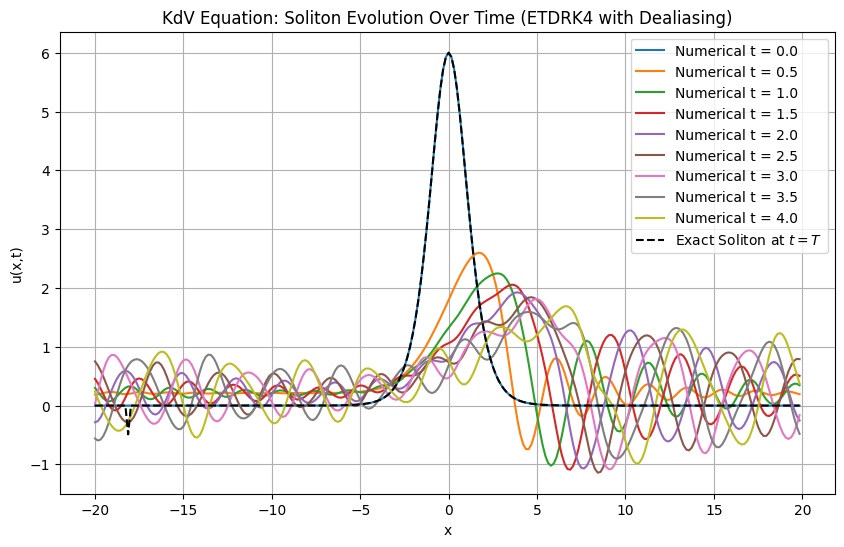

In [10]:
# Fixing the dealiasing issue by correctly defining the cutoff inside the loop

# Parameters
L = 40  # Domain length (larger to fit soliton)
N = 256  # Increased resolution
dx = L / N  # Grid spacing
dt = 0.001  # Smaller time step for stability
T = 4  # Final time
h = 0.5  # Time step for saving intermediate solutions

# Soliton parameters
c = 2.0  # Soliton speed
A = 3 * c  # Soliton amplitude
W = np.sqrt(4 / c)  # Soliton width

# Spatial domain
x = np.linspace(-L/2, L/2, N, endpoint=False)
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi  # Wavenumbers

# Initial condition: Single Soliton
u0 = A * np.cosh((x) / W) ** -2

# Fourier transform of initial condition
u_hat = fft(u0)

# Define the linear and nonlinear operators
L_disp = -1j * k**3  # Linear dispersive term
dealiasing_cutoff = int(N / 3)  # Define dealiasing cutoff

# Function to compute the nonlinear term in Fourier space with dealiasing
def compute_nonlinear_term(u_hat):
    u = np.real(ifft(u_hat))
    u_squared_hat = fft(u**2)
    
    # Apply 2/3 dealiasing rule (zero out high-frequency modes)
    u_squared_hat[dealiasing_cutoff:] = 0
    
    nonlinear_term = -1j * k * u_squared_hat
    return nonlinear_term

# Time integration using ETDRK4 with dealiasing
t = 0
solutions = [(t, u0)]  # Store solutions at each step

while t < T:
    # Compute nonlinear term in Fourier space
    N_hat = compute_nonlinear_term(u_hat)

    # First step
    a = np.exp(dt * L_disp / 2) * u_hat + dt / 2 * N_hat
    Na = compute_nonlinear_term(a)

    # Second step
    b = np.exp(dt * L_disp / 2) * u_hat + dt / 2 * Na
    Nb = compute_nonlinear_term(b)

    # Third step
    c = np.exp(dt * L_disp / 2) * a + dt * (2 * Nb - N_hat)
    Nc = compute_nonlinear_term(c)

    # Final update
    u_hat = np.exp(dt * L_disp) * u_hat + dt / 6 * (N_hat + 2 * (Na + Nb) + Nc)

    # Apply dealiasing after each time step
    u_hat[dealiasing_cutoff:] = 0

    # Update time
    t += dt

    # Save solution at intervals
    if abs(t - solutions[-1][0] - h) < dt:
        solutions.append((t, np.real(ifft(u_hat))))

# Exact soliton solution for comparison
def exact_soliton(x, t, c):
    return A * np.cosh((x - c * t) / W) ** -2

# Plot numerical and exact solutions
plt.figure(figsize=(10, 6))
for t, u_sol in solutions:
    plt.plot(x, u_sol, label=f"Numerical t = {t:.1f}")

# Plot exact solution at final time
plt.plot(x, exact_soliton(x, T, c), '--k', label="Exact Soliton at $t=T$")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("KdV Equation: Soliton Evolution Over Time (ETDRK4 with Dealiasing)")
plt.grid()
plt.show()


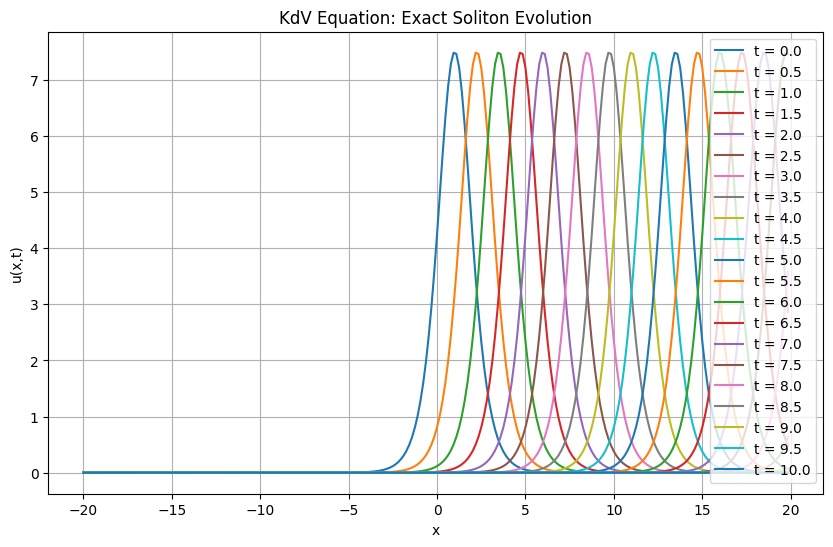

In [11]:
# Fixing issues:
# - The numerical solution is removed
# - The loop correctly iterates over time values, not spatial x values
# - The soliton is computed over time, not just space

import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 40  # Domain length (larger to fit soliton)
N = 256  # Increased resolution
dx = L / N  # Grid spacing
T = 10  # Final time
h = 0.5  # Time step for saving intermediate solutions

# Soliton parameters
a = 1.0 
c = 2.5  # Soliton speed
A = 3 * c  # Soliton amplitude
W = np.sqrt(4 / c)  # Soliton width

# Spatial domain
x = np.linspace(-L/2, L/2, N, endpoint=False)
t_values = np.arange(0, T + h, h)  # Time steps for saving solutions

# Fix: Apply clamping to prevent overflow in cosh
def exact_soliton(x, t, c, a):
    arg = np.clip(np.sqrt(c) * (x - c * t - a) / 2, -50, 50)  # Prevent extreme values
    return A / np.cosh(arg) ** 2  # Stable sech^2 computation

# Generate exact solutions at saved time steps
exact_solutions = [(t, exact_soliton(x, t, c, a)) for t in t_values]

# Plot exact solutions over time
plt.figure(figsize=(10, 6))
for t, u_exact in exact_solutions:
    plt.plot(x, u_exact, label=f"t = {t:.1f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("KdV Equation: Exact Soliton Evolution")
plt.grid()
plt.show()


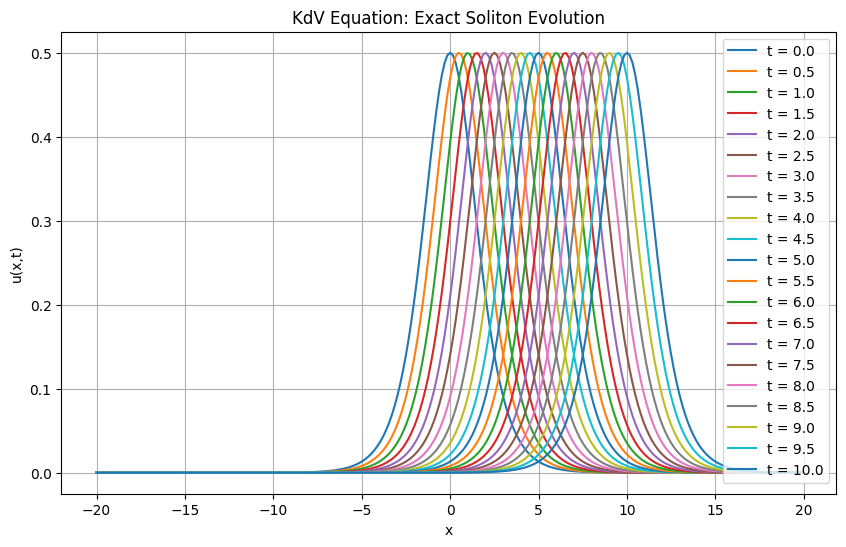

In [12]:
# Fixing issues:
# - The numerical solution is removed
# - The loop correctly iterates over time values, not spatial x values
# - The soliton is computed over time, not just space

import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 40  # Domain length (larger to fit soliton)
N = 256  # Increased resolution
dx = L / N  # Grid spacing
T = 10  # Final time
h = 0.5  # Time step for saving intermediate solutions

# Soliton parameters
a = 0.0 
c = 1.0  # Soliton speed
A = 3 * c  # Soliton amplitude
W = np.sqrt(1000 / c)  # Soliton width

# Spatial domain
x = np.linspace(-L/2, L/2, N, endpoint=False)
t_values = np.arange(0, T + h, h)  # Time steps for saving solutions

# Fix: Apply clamping to prevent overflow in cosh
def exact_soliton(x, t, c, a):
    arg = np.clip(np.sqrt(c) * (x - c * t - a) / 2, -50, 50)  # Prevent extreme values
    return (c / 2) / np.cosh(arg) ** 2  # Stable sech^2 computation

# Generate exact solutions at saved time steps
exact_solutions = [(t, exact_soliton(x, t, c, a)) for t in t_values]

# Plot exact solutions over time
plt.figure(figsize=(10, 6))
for t, u_exact in exact_solutions:
    plt.plot(x, u_exact, label=f"t = {t:.1f}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("KdV Equation: Exact Soliton Evolution")
plt.grid()
plt.show()


In [30]:
a = 0.0 
c = 2.5  # Soliton speed

u0 = exact_soliton(x, 0, c, a)
u_hat = fft(u0)

# Get complex conjugate of Fourier coefficients
u_hat_conj = np.conj(u_hat)
print("Complex conjugate of Fourier coefficients:")

# Calculate L2 norm using Parseval's theorem
# The L2 norm of a function equals the L2 norm of its Fourier coefficients (up to a constant)
L2_norm = np.sqrt(np.sum(u_hat*np.conj(u_hat))) /L
print(f"L2 norm of the soliton solution: {L2_norm:.6f}")

L2_norm = np.sqrt(np.sum(np.abs(u_hat)**2)) / L
print(f"L2 norm of the soliton solution: {L2_norm:.6f}")


# We can also verify this by computing the L2 norm directly in physical space
L2_norm_direct = np.sqrt(np.sum(np.abs(u0)**2) * dx)
print(f"L2 norm computed directly: {L2_norm_direct:.6f}")

# We can also verify this by computing the L2 norm directly using numerical integration
# Using trapezoidal rule for numerical integration
L2_norm_numerical = np.sqrt(np.trapz(np.abs(u0)**2, x))
print(f"L2 norm computed using numerical integration: {L2_norm_numerical:.6f}")



Complex conjugate of Fourier coefficients:
L2 norm of the soliton solution: 1.642704+0.000000j
L2 norm of the soliton solution: 1.642704
L2 norm computed directly: 1.623340
L2 norm computed using numerical integration: 1.623340


/var/folders/9z/g5qd8cf95dg743cjhmdb6zsw0000gn/T/ipykernel_55932/637224560.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  L2_norm_numerical = np.sqrt(np.trapz(np.abs(u0)**2, x))


In [39]:
import torch

def padded_ifft(four_coef_hat, K):
    """
    Compute the inverse Fourier transform with zero-padding to match a target resolution K.
    Handles batched input tensors.
    
    Parameters:
        four_coef_hat (torch.Tensor): Tensor of shape (batch_size, N) containing Fourier coefficients
        K (int): The target number of points for the output resolution
    
    Returns:
        torch.Tensor: The reconstructed function sampled at K points, shape (batch_size, K)
    """
    N = len(four_coef_hat)  # Original number of Fourier modes

    # Zero-padding in Fourier space
    if K > N:
        pad_left = (K - N) // 2
        pad_right = K - N - pad_left
        four_coef_hat_padded = torch.nn.functional.pad(four_coef_hat, (pad_left, pad_right), mode='constant', value=0)
    else:
        # If K <= N, truncate the higher frequencies
        four_coef_hat_padded = four_coef_hat[:K]

    # Compute the inverse FFT
    out = np.fft.ifft(four_coef_hat_padded) * (K / N)  # Adjust scaling factor

    return out




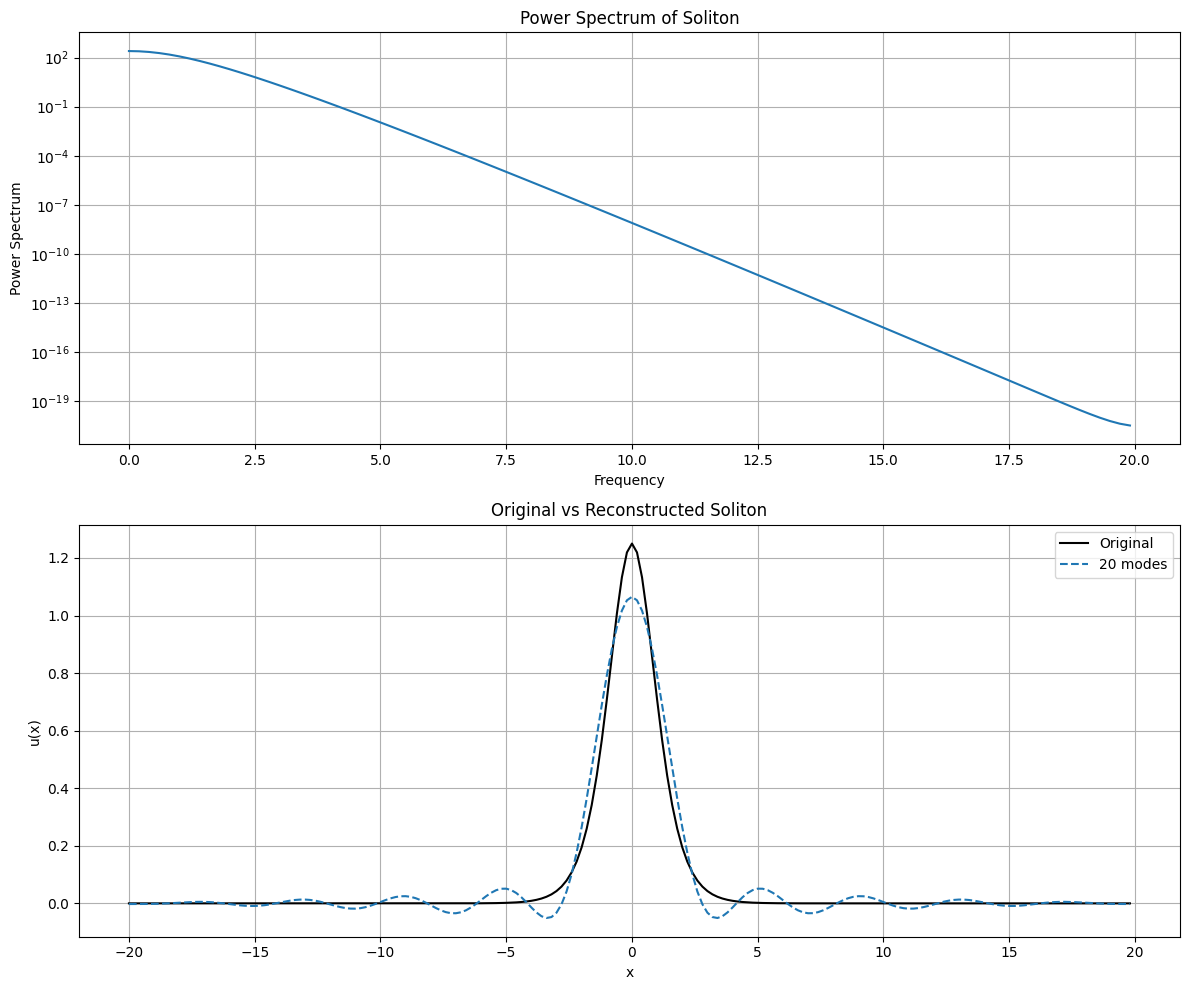

In [44]:
N = 200
x = np.linspace(-L/2, L/2, N, endpoint=False)


# Take the soliton function at t=0 for spectral analysis
u0 = exact_soliton(x, 0, c, a)

# Compute DFT
u_hat = fft(u0)
frequencies = np.fft.fftfreq(N, dx/(2*np.pi))

# Compute power spectrum
power_spectrum = np.abs(u_hat)**2

# Plot original signal, DFT magnitude, and reconstructions with different modes
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot power spectrum
axs[0].semilogy(frequencies[:N//2], power_spectrum[:N//2])
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Power Spectrum')
axs[0].set_title('Power Spectrum of Soliton')
axs[0].grid(True)

# Plot original and reconstructions
axs[1].plot(x, u0, 'k-', label='Original')

# Try different numbers of modes for reconstruction
for n_modes in [10]:
    u_hat_truncated = u_hat.copy()
    u_hat_truncated[n_modes:-n_modes] = 0  # Keep only n_modes at the start and end
    
    
    padded = np.real(padded_ifft(u_hat_truncated, 200))
    # u_reconstructed = np.real(ifft(u_hat_truncated))
    axs[1].plot(x, padded, '--', label=f'{2*n_modes} modes')

axs[1].set_xlabel('x')
axs[1].set_ylabel('u(x)')
axs[1].set_title('Original vs Reconstructed Soliton')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [18]:
print(u0)

[4.12230723e-09 4.81946542e-09 5.63452592e-09 6.58742818e-09
 7.70148379e-09 9.00394675e-09 1.05266802e-08 1.23069360e-08
 1.43882659e-08 1.68215870e-08 1.96664276e-08 2.29923832e-08
 2.68808192e-08 3.14268614e-08 3.67417232e-08 4.29554260e-08
 5.02199806e-08 5.87131052e-08 6.86425736e-08 8.02512981e-08
 9.38232716e-08 1.09690516e-07 1.28241203e-07 1.49929153e-07
 1.75284934e-07 2.04928843e-07 2.39586082e-07 2.80104497e-07
 3.27475319e-07 3.82857415e-07 4.47605637e-07 5.23303967e-07
 6.11804267e-07 7.15271580e-07 8.36237097e-07 9.77660077e-07
 1.14300024e-06 1.33630241e-06 1.56229544e-06 1.82650794e-06
 2.13540346e-06 2.49653867e-06 2.91874818e-06 3.41236066e-06
 3.98945149e-06 4.66413817e-06 5.45292567e-06 6.37511011e-06
 7.45325079e-06 8.71372200e-06 1.01873581e-05 1.19102078e-05
 1.39244156e-05 1.62792527e-05 1.90323223e-05 2.22509674e-05
 2.60139186e-05 3.04132182e-05 3.55564716e-05 4.15694768e-05
 4.85993005e-05 5.68178717e-05 6.64261835e-05 7.76592040e-05
 9.07916155e-05 1.061445

In [34]:
trunk_t = np.linspace(0, 10, 10)
trunk_x = np.linspace(-20, 20, 20)

X, T = np.meshgrid(trunk_x, trunk_t)
trunk_data = np.column_stack((T.flatten(), X.flatten()))
print(trunk_data)

[[  0.         -20.        ]
 [  0.         -17.89473684]
 [  0.         -15.78947368]
 [  0.         -13.68421053]
 [  0.         -11.57894737]
 [  0.          -9.47368421]
 [  0.          -7.36842105]
 [  0.          -5.26315789]
 [  0.          -3.15789474]
 [  0.          -1.05263158]
 [  0.           1.05263158]
 [  0.           3.15789474]
 [  0.           5.26315789]
 [  0.           7.36842105]
 [  0.           9.47368421]
 [  0.          11.57894737]
 [  0.          13.68421053]
 [  0.          15.78947368]
 [  0.          17.89473684]
 [  0.          20.        ]
 [  1.11111111 -20.        ]
 [  1.11111111 -17.89473684]
 [  1.11111111 -15.78947368]
 [  1.11111111 -13.68421053]
 [  1.11111111 -11.57894737]
 [  1.11111111  -9.47368421]
 [  1.11111111  -7.36842105]
 [  1.11111111  -5.26315789]
 [  1.11111111  -3.15789474]
 [  1.11111111  -1.05263158]
 [  1.11111111   1.05263158]
 [  1.11111111   3.15789474]
 [  1.11111111   5.26315789]
 [  1.11111111   7.36842105]
 [  1.11111111